# Scraping reviews

In [71]:
pip install google-play-scraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk
import numpy

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
import json
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [73]:
app_package = 'com.byu.id'

info = app(app_package, lang='en', country='us')
del info['comments']
info

{'title': 'by.U-The All-Digital Provider',
 'description': 'by.U know how irritating it is to have a strict mobile plan and surprising terms and conditions. Here are 4 reasons why you should leave your Ex and move on to by.U :)\r\n\r\n1. No time & location-based rules\r\nWe offer worry-free quota without any restriction on time, location, and speed. Use it whenever on whatever apps you like. Go get, "Yang Bikin Nagih" 10 GB data quota for only Rp 50,000 now!\r\n\r\n2. Affordable topping quota for your favorite apps\r\nYou like music? go buy music quota. You like watching movie? go buy movie quota. Don\'t let yourself buy something that you don\'t really like. Topping quota start from Rp 5,000.  What are you waiting for?\r\n\r\n3. Choose your own number and enjoy all service in one apps\r\nNo need to go out to get by.U! Choose number only by tapping your screen. Manage all the usage, make payment, and contact customer service through by.U apps\r\n\r\n4. Get your SIM Card delivered\r\n O

In [74]:
def print_json(json_object):
  json_str = json.dumps(
    json_object,
    indent=2,
    sort_keys=True,
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [75]:
print_json(info)

{
  "adSupported": false,
  "appId": "com.byu.id",
  "containsAds": false,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "by.U know how irritating it is to have a strict mobile plan and surprising terms and conditions. Here are 4 reasons why you should leave your Ex and move on to by.U :)\r\n\r\n1. No time & location-based rules\r\nWe offer worry-free quota without any restriction on time, location, and speed. Use it whenever on whatever apps you like. Go get, \"Yang Bikin Nagih\" 10 GB data quota for only Rp 50,000 now!\r\n\r\n2. Affordable topping quota for your favorite apps\r\nYou like music? go buy music quota. You like watching movie? go buy movie quota. Don't let yourself buy something that you don't really like. Topping quota start from Rp 5,000.  What are you waiting for?\r\n\r\n3. Choose your own number and enjoy all service in one apps\r\nNo need to go out to get by.U! Choose number only by tapping your screen. Manag

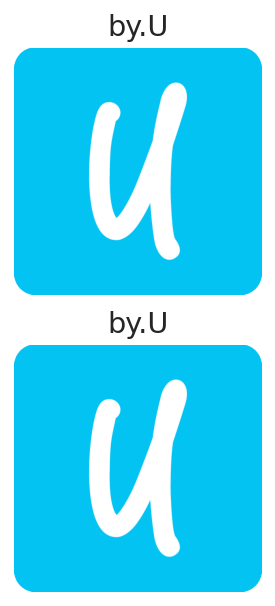

In [76]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(2, 1 // 1, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
  ai = info
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')

In [77]:
info_df = pd.DataFrame(info)
info_df.to_csv('app.csv', index=None, header=True)

ValueError: ignored

In [78]:
app_reviews = []

for score in list(range(1, 6)):
  for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
    rvs, _ = reviews(
      app_package,
      lang='en',
      country='us',
      sort=sort_order,
      count= 10000
    )
    for r in rvs:
      r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
      r['appId'] = app_package
    app_reviews.extend(rvs)

In [79]:
print_json(app_reviews[0])

{
  "appId": "com.byu.id",
  "at": "2022-09-12 09:31:26",
  "content": "Been around 2 years using this. Data plan prices rising but connection gets worse, not to mention the occasional blank signal. Useless features that I and other users barely even use. And most of all, please, just please don't include Disney Hotstar/Tiktok and other apps combo/automatic subs in every single of your data plan. I quitted Telkomsel cuz of those super annoying combos so pls drop them out! \ud83d\ude29",
  "repliedAt": "2022-09-12 09:37:49",
  "replyContent": "Hi Sis Rafaela, Sorry for making you uncomfortable. For the problem, change the network mode from automatic to manual 2g only, then turn it back to automatic mode or try airplane mode. If this method is still having problems, you can tell Nindy on DM IG @byu.id or LiveChat on the app, Sis :)",
  "reviewCreatedVersion": "869",
  "reviewId": "3b1bf9b9-546c-4074-84c2-a77a1d46b7e0",
  "score": 2,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 2,
 

In [80]:
len(app_reviews)

100000

In [81]:
df = pd.DataFrame(app_reviews)
df.to_csv('reviews.csv', index=None, header=True)

# Preparing dataset

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              100000 non-null  object        
 1   userName              100000 non-null  object        
 2   userImage             100000 non-null  object        
 3   content               100000 non-null  object        
 4   score                 100000 non-null  int64         
 5   thumbsUpCount         100000 non-null  int64         
 6   reviewCreatedVersion  92555 non-null   object        
 7   at                    100000 non-null  datetime64[ns]
 8   replyContent          92150 non-null   object        
 9   repliedAt             92150 non-null   datetime64[ns]
 10  sortOrder             100000 non-null  object        
 11  appId                 100000 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 9.2

In [83]:
cs = df.drop(['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'sortOrder', 'appId'], axis=1)
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  100000 non-null  object
 1   score    100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [84]:
cs.head()

,content,score
0,Been around 2 years using this. Data plan pric...,2
1,I was already done with my warm up before goin...,1
2,"first, the app has too much features which is ...",1
3,"At first i love this provider, very affordable...",1
4,This app is very disappointing and unreliable....,1


In [85]:
cs.value_counts('score')

score
5    39190
1    33460
4     9640
3     9000
2     8710
dtype: int64

In [ ]:
# y = cs.score
# X = cs.drop('score', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=25)
# X = pd.concat([X_train, y_train], axis=1)

In [86]:
score1 = cs[cs.score==1]
score2 = cs[cs.score==2]
score3 = cs[cs.score==3]
score4 = cs[cs.score==4]
score5 = cs[cs.score==5]

In [101]:
score12 = pd.concat([score1, score2])
score45 = pd.concat([score4, score5])

In [102]:
score12['label'] = 0

In [103]:
score45['label'] = 1

In [104]:
score12.head()

,content,score,label
1,I was already done with my warm up before goin...,1,0
2,"first, the app has too much features which is ...",1,0
3,"At first i love this provider, very affordable...",1,0
4,This app is very disappointing and unreliable....,1,0
5,"This app is just not made for foreigners, you ...",1,0


In [105]:
score45.head()

,content,score,label
21,Working great on Android phones. Need to maint...,4,1
28,"Easy to use, simple, clear, efficient, and nic...",4,1
30,The application was great. Eye-friendly with l...,4,1
46,I prefer to recommended by.U due to values and...,4,1
51,"Can't even login to app, always failed using b...",4,1


In [106]:
train_set = pd.concat([score12, score45])

In [107]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91000 entries, 1 to 99997
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  91000 non-null  object
 1   score    91000 non-null  int64 
 2   label    91000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.8+ MB


In [108]:
train_set.value_counts('score')

score
5    39190
1    33460
4     9640
2     8710
dtype: int64

In [135]:
new_df = train_set.drop(columns='score')
new_df

,content,label
1,I was already done with my warm up before goin...,0
2,"first, the app has too much features which is ...",0
3,"At first i love this provider, very affordable...",0
4,This app is very disappointing and unreliable....,0
5,"This app is just not made for foreigners, you ...",0
...,...,...
99991,wajib punya,1
99993,"pembelian paket mudah, user interface simple g...",1
99995,Favvvvv,1
99996,"by. U, smooth and reliable, straight forward d...",1


In [110]:
category = pd.get_dummies(new_df.label)
new_df = pd.concat([new_df, category], axis=1)
new_df = new_df.drop(columns='label')
new_df

,content,0,1
1,I was already done with my warm up before goin...,1,0
2,"first, the app has too much features which is ...",1,0
3,"At first i love this provider, very affordable...",1,0
4,This app is very disappointing and unreliable....,1,0
5,"This app is just not made for foreigners, you ...",1,0
...,...,...,...
99991,wajib punya,0,1
99993,"pembelian paket mudah, user interface simple g...",0,1
99995,Favvvvv,0,1
99996,"by. U, smooth and reliable, straight forward d...",0,1


In [111]:
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

def remove_punctuation(data):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  clean_text = tokenizer.tokenize(data)
  return(clean_text)
  new_df.content = new_df.content.apply(lambda x: x.remove_punctuation(x))

new_df.content = new_df.content.apply(lambda x: x.lower())

def remove_stopwords(data):
  word_tokens = word_tokenize(data)
  clean_text = [words for words in word_tokens if not words.lower() in stop_words]
  clean_text = []
  for words in word_tokens:
    if words not in stop_words:
      clean_text.append(words)
  return(clean_text)
  new_df.content = new_df.content.apply(lambda x: x.remove_stopwords(x))

def lem_word(data):
  word_tokens = word_tokenize(data)
  for words in word_tokens:
    words = wnl.lemmatize(words)
  return(words)
  new_df.content = new_df.content.apply(lambda x: x.lem_word(x))

In [112]:
new_df

,content,0,1
1,i was already done with my warm up before goin...,1,0
2,"first, the app has too much features which is ...",1,0
3,"at first i love this provider, very affordable...",1,0
4,this app is very disappointing and unreliable....,1,0
5,"this app is just not made for foreigners, you ...",1,0
...,...,...,...
99991,wajib punya,0,1
99993,"pembelian paket mudah, user interface simple g...",0,1
99995,favvvvv,0,1
99996,"by. u, smooth and reliable, straight forward d...",0,1


In [113]:
text = new_df['content'].values
label = new_df[[0, 1]].values

In [114]:
train_text, test_text, train_label, test_label = train_test_split(text, label, test_size=0.2, 
                                                                  shuffle=True, random_state=25)

In [115]:
tokenizer = Tokenizer(num_words=10000, oov_token='x')

tokenizer.fit_on_texts(train_text)

train_sequence = tokenizer.texts_to_sequences(train_text)
test_sequence = tokenizer.texts_to_sequences(test_text)
 
train_padded = pad_sequences(train_sequence, padding='post', maxlen=35, truncating='post')
test_padded = pad_sequences(test_sequence, padding='post', maxlen=35, truncating='post')

In [116]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=10000, output_dim=100, input_length=35),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Bidirectional(LSTM(64)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 100)           1000000   
                                                                 
 dropout_6 (Dropout)         (None, 35, 100)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                      

In [117]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98 and logs.get('val_accuracy')>0.98):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 98%!")
callbacks = myCallback()

In [118]:
num_epochs = 50
history = model.fit(train_padded, train_label, epochs=num_epochs,
                    validation_data=(test_padded, test_label), verbose=2, 
                    callbacks=[callbacks], validation_steps=30)

Epoch 1/50
2275/2275 - 67s - loss: 0.1580 - accuracy: 0.9425 - val_loss: 0.0659 - val_accuracy: 0.9794 - 67s/epoch - 30ms/step
Epoch 2/50

The accuracy of the training set and the validation set has reached > 98%!
2275/2275 - 65s - loss: 0.0434 - accuracy: 0.9868 - val_loss: 0.0302 - val_accuracy: 0.9905 - 65s/epoch - 28ms/step


In [123]:
test_text = score3.content.values

In [124]:
X = tokenizer.texts_to_sequences(test_text)
X = pad_sequences(X, padding='post', maxlen=35, truncating='post')

In [125]:
model.predict(X)

array([[9.9877256e-01, 1.2274659e-03],
       [1.8774798e-03, 9.9812251e-01],
       [4.2787818e-08, 1.0000000e+00],
       ...,
       [3.3159603e-03, 9.9668401e-01],
       [7.5239545e-01, 2.4760453e-01],
       [9.9865985e-01, 1.3400957e-03]], dtype=float32)

In [126]:
y = (model.predict(X)>0.5).astype(int)
y

array([[1, 0],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

In [127]:
reslabel = numpy.array(y)
reslabel[:,1]

array([0, 1, 1, ..., 1, 0, 0])

In [133]:
score3['label'] = reslabel[:,1]

In [134]:
score3

,content,label
8,"The apps look good, but the signal becomes wor...",0
10,"Overall is good, you should find out the probl...",1
25,So far my experience has been great. Nothing p...,1
27,Been using this provider for at least one year...,0
38,"Very good provider, the app is comprehensive a...",1
...,...,...
99953,termasuk mahal,0
99959,Applikasinya kenapa bro ga bisa login pakai no...,0
99967,This is good provider. But i hope they will ma...,1
99973,For now I give 3 Stars.. Just see forward..,0


In [130]:
score3 = score3.drop('score', axis=1)
score3

In [136]:
byu_review = pd.concat([new_df, score3])

In [137]:
byu_review

,content,label
1,I was already done with my warm up before goin...,0
2,"first, the app has too much features which is ...",0
3,"At first i love this provider, very affordable...",0
4,This app is very disappointing and unreliable....,0
5,"This app is just not made for foreigners, you ...",0
...,...,...
99953,termasuk mahal,0
99959,Applikasinya kenapa bro ga bisa login pakai no...,0
99967,This is good provider. But i hope they will ma...,1
99973,For now I give 3 Stars.. Just see forward..,0


In [138]:
byu_review.to_csv('byu_review.csv', index=None, header=True)